# **Import Needed Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **EDA**

In [ ]:
df = pd.read_csv("/content/linkedin_jobs.csv")
df

job_id          job_title  \
0     3757935025       Veterinarian   
1     3757934327       Veterinarian   
2     3757933458       Veterinarian   
3     3757932826       Veterinarian   
4     3757931806       Veterinarian   
...          ...                ...   
2574  3685418185  Software Engineer   
2575  3684441939         Accountant   
2576  3682818140          Developer   
2577  3663878663         Accountant   
2578  2148434032   Tax Professional   

                                               job_desc experience_level  \
0     We are looking to hire an Associate Veterinari...           Senior   
1     We are looking to hire an Associate Veterinari...           Senior   
2     We are looking to hire an Associate Veterinari...           Senior   
3     We are looking to hire an Associate Veterinari...           Senior   
4     We are looking to hire an Associate Veterinari...           Senior   
...                                                 ...              ...   
2574  Who we are:Founded in 2017, Gatik is the leade...           Senior   
2575  Titus Talent Strategies has partnered with SAR...         Beginner   
2576  Carefully read the JD before applying!Job Desc...           Senior   
2577  Bring YOUR energy to Alliant Energy!\n\nAt All...         Beginner   
2578  RaceTrac Company Overview\n\nJob Description:\...         Beginner   

      work_type      location    industry  \
0     Full-time      Michigan  Healthcare   
1     Full-time      Colorado  Healthcare   
2     Full-time    California  Healthcare   
3     Full-time  Pennsylvania  Healthcare   
4     Full-time      New York  Healthcare   
...         ...           ...         ...   
2574  Full-time    California          IT   
2575  Full-time     Wisconsin     Finance   
2576   Contract         Texas          IT   
2577  Full-time     Wisconsin     Finance   
2578  Full-time       Georgia     Finance   

                                        job_posting_url  
0     https://www.linkedin.com/jobs/view/3757935025/...  
1     https://www.linkedin.com/jobs/view/3757934327/...  
2     https://www.linkedin.com/jobs/view/3757933458/...  
3     https://www.linkedin.com/jobs/view/3757932826/...  
4     https://www.linkedin.com/jobs/view/3757931806/...  
...                                                 ...  
2574  https://www.linkedin.com/jobs/view/3685418185/...  
2575  https://www.linkedin.com/jobs/view/3684441939/...  
2576  https://www.linkedin.com/jobs/view/3682818140/...  
2577  https://www.linkedin.com/jobs/view/3663878663/...  
2578  https://www.linkedin.com/jobs/view/2148434032/...  

[2579 rows x 8 columns]

In [ ]:
# Know the columns/attributes/features we're dealing with
df.columns

Index(['job_id', 'job_title', 'job_desc', 'experience_level', 'work_type',
       'location', 'industry', 'job_posting_url'],
      dtype='object')

In [ ]:
# Know the datatypes we're dealing with
df.dtypes

job_id               int64
job_title           object
job_desc            object
experience_level    object
work_type           object
location            object
industry            object
job_posting_url     object
dtype: object

In [ ]:
# Print a concise summary of a DataFrame. This method prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            2579 non-null   int64 
 1   job_title         2579 non-null   object
 2   job_desc          2579 non-null   object
 3   experience_level  2579 non-null   object
 4   work_type         2579 non-null   object
 5   location          2579 non-null   object
 6   industry          2579 non-null   object
 7   job_posting_url   2579 non-null   object
dtypes: int64(1), object(7)
memory usage: 161.3+ KB


## **Industry Distribution**

Text(0.5, 1.0, 'Distribution of Industry')

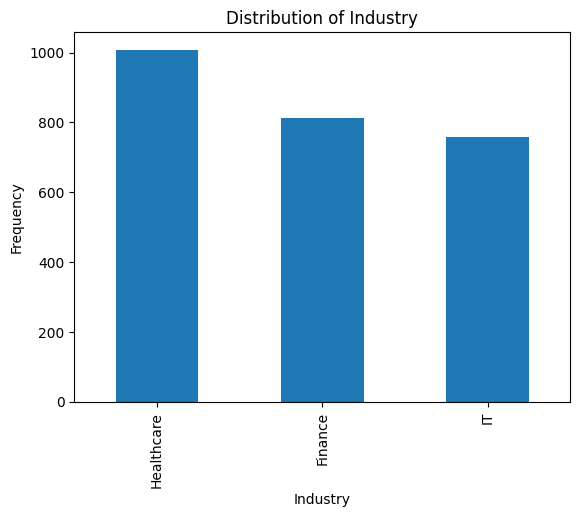

In [ ]:
# Check value counts
df['industry'].value_counts().plot(kind='bar')
plt.xlabel('Industry')
plt.ylabel('Frequency')
plt.title('Distribution of Industry')

## **Job Title Distribution**

Text(0.5, 1.0, 'Distribution of Job Titles')

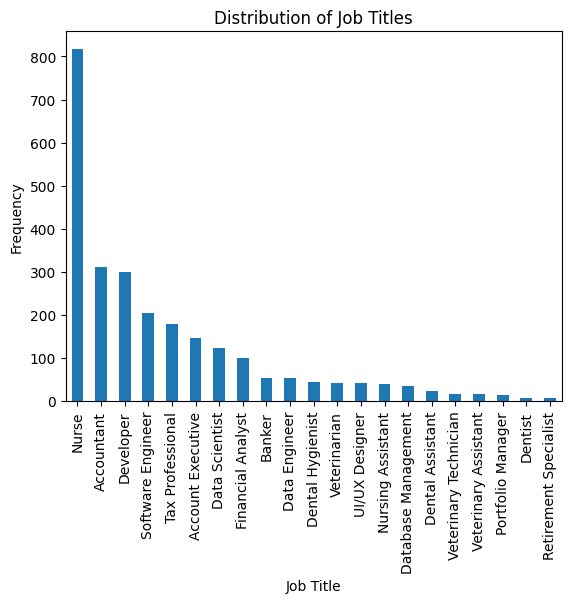

In [ ]:
# Check value counts
df['job_title'].value_counts().plot(kind='bar')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.title('Distribution of Job Titles')

As we can see, the dataset is imbalanced. Healthcare jobs and especially Nurse jobs are dominant in our dataset. We will address this imbalance by dropping some nurse jobs.

## **Balance the dataset by randomly removing some Nurse jobs**

In [ ]:
# Randomly drop 250 rows
to_drop = df[df['job_title']=='Nurse'].sample(250, random_state=42)

In [ ]:
df = df.drop(to_drop.index)
df= df.reset_index(drop=True)
df

job_id          job_title  \
0     3757935025       Veterinarian   
1     3757934327       Veterinarian   
2     3757933458       Veterinarian   
3     3757932826       Veterinarian   
4     3757931806       Veterinarian   
...          ...                ...   
2324  3685418185  Software Engineer   
2325  3684441939         Accountant   
2326  3682818140          Developer   
2327  3663878663         Accountant   
2328  2148434032   Tax Professional   

                                               job_desc experience_level  \
0     We are looking to hire an Associate Veterinari...           Senior   
1     We are looking to hire an Associate Veterinari...           Senior   
2     We are looking to hire an Associate Veterinari...           Senior   
3     We are looking to hire an Associate Veterinari...           Senior   
4     We are looking to hire an Associate Veterinari...           Senior   
...                                                 ...              ...   
2324  Who we are:Founded in 2017, Gatik is the leade...           Senior   
2325  Titus Talent Strategies has partnered with SAR...         Beginner   
2326  Carefully read the JD before applying!Job Desc...           Senior   
2327  Bring YOUR energy to Alliant Energy!\n\nAt All...         Beginner   
2328  RaceTrac Company Overview\n\nJob Description:\...         Beginner   

      work_type      location    industry  \
0     Full-time      Michigan  Healthcare   
1     Full-time      Colorado  Healthcare   
2     Full-time    California  Healthcare   
3     Full-time  Pennsylvania  Healthcare   
4     Full-time      New York  Healthcare   
...         ...           ...         ...   
2324  Full-time    California          IT   
2325  Full-time     Wisconsin     Finance   
2326   Contract         Texas          IT   
2327  Full-time     Wisconsin     Finance   
2328  Full-time       Georgia     Finance   

                                        job_posting_url  
0     https://www.linkedin.com/jobs/view/3757935025/...  
1     https://www.linkedin.com/jobs/view/3757934327/...  
2     https://www.linkedin.com/jobs/view/3757933458/...  
3     https://www.linkedin.com/jobs/view/3757932826/...  
4     https://www.linkedin.com/jobs/view/3757931806/...  
...                                                 ...  
2324  https://www.linkedin.com/jobs/view/3685418185/...  
2325  https://www.linkedin.com/jobs/view/3684441939/...  
2326  https://www.linkedin.com/jobs/view/3682818140/...  
2327  https://www.linkedin.com/jobs/view/3663878663/...  
2328  https://www.linkedin.com/jobs/view/2148434032/...  

[2329 rows x 8 columns]

Text(0.5, 1.0, 'Distribution of Industry')

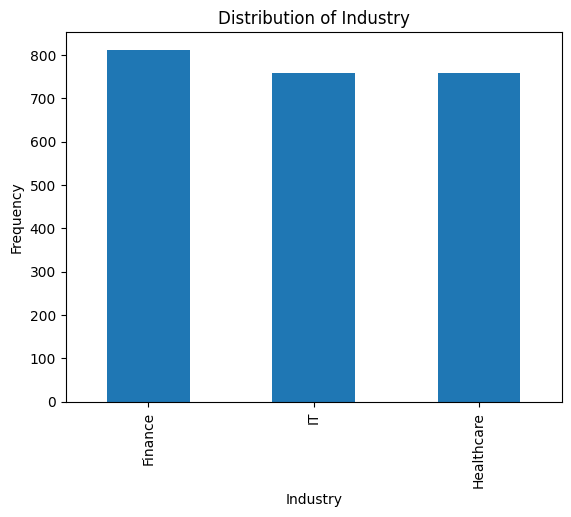

In [ ]:
# Check value counts
df['industry'].value_counts().plot(kind='bar')
plt.xlabel('Industry')
plt.ylabel('Frequency')
plt.title('Distribution of Industry')

As we can see, dataset is much more balanced now.

Text(0.5, 1.0, 'Distribution of Job Titles')

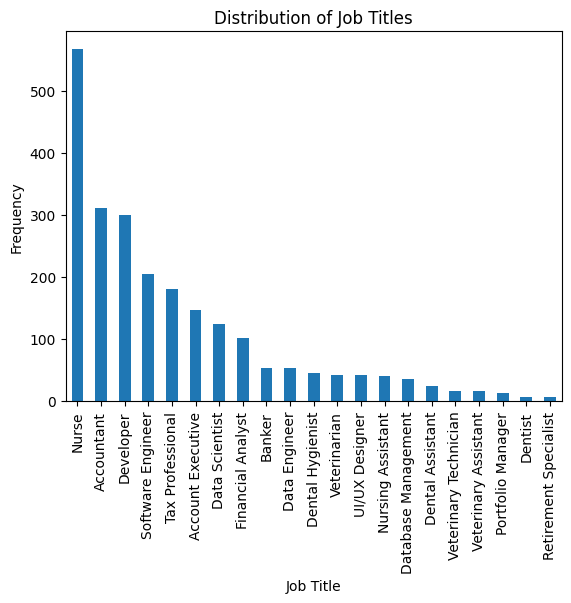

In [ ]:
# Check value counts
df['job_title'].value_counts().plot(kind='bar')
plt.xlabel('Job Title')
plt.ylabel('Frequency')
plt.title('Distribution of Job Titles')

## **Distribution of Experience Level**

Text(0.5, 1.0, 'Distribution of Experience Level')

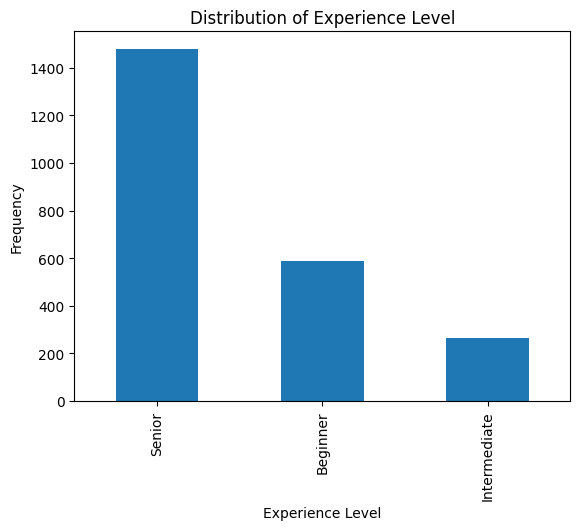

In [ ]:
# Check value counts
df['experience_level'].value_counts().plot(kind='bar')
plt.xlabel('Experience Level')
plt.ylabel('Frequency')
plt.title('Distribution of Experience Level')

## **Distribution of Work Type**

Text(0.5, 1.0, 'Distribution of Work Type')

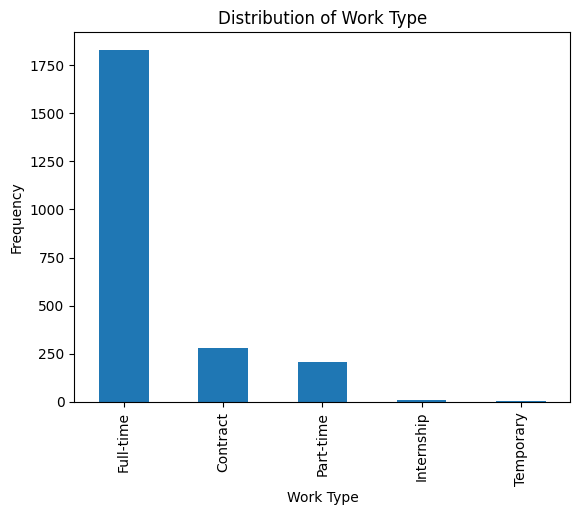

In [ ]:
# Check value counts
df['work_type'].value_counts().plot(kind='bar')
plt.xlabel('Work Type')
plt.ylabel('Frequency')
plt.title('Distribution of Work Type')

## **Distribution of Location**

Text(0.5, 1.0, 'Distribution of Location')

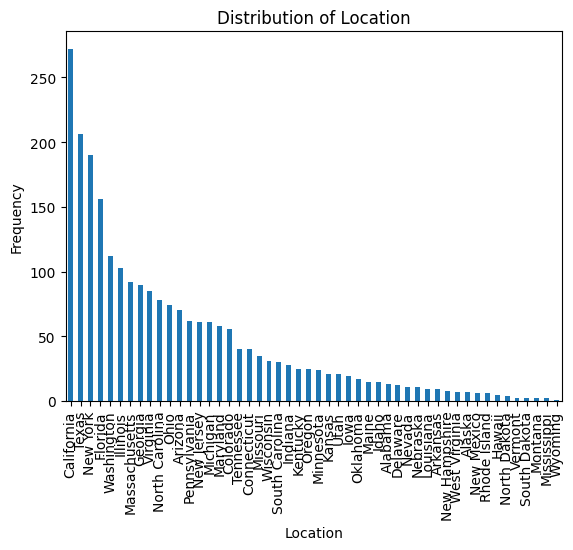

In [ ]:
# Check value counts
df['location'].value_counts().plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Distribution of Location')

# **Text Preprocessing**

## **Concatenate Text Data**

Creating "concatenated" column to merge all the values of the attributes that will be used in the clustering and classification task.

In [ ]:
# Join all relevant features into column 'texts'
df['texts'] =  df['job_title'] + ' ' + df['job_desc'] + ' ' + df['experience_level'] + ' ' + df['work_type'] + ' ' + df['location'] + ' '+ df['industry']
df.head()

job_id     job_title  \
0  3757935025  Veterinarian   
1  3757934327  Veterinarian   
2  3757933458  Veterinarian   
3  3757932826  Veterinarian   
4  3757931806  Veterinarian   

                                            job_desc experience_level  \
0  We are looking to hire an Associate Veterinari...           Senior   
1  We are looking to hire an Associate Veterinari...           Senior   
2  We are looking to hire an Associate Veterinari...           Senior   
3  We are looking to hire an Associate Veterinari...           Senior   
4  We are looking to hire an Associate Veterinari...           Senior   

   work_type      location    industry  \
0  Full-time      Michigan  Healthcare   
1  Full-time      Colorado  Healthcare   
2  Full-time    California  Healthcare   
3  Full-time  Pennsylvania  Healthcare   
4  Full-time      New York  Healthcare   

                                     job_posting_url  \
0  https://www.linkedin.com/jobs/view/3757935025/...   
1  https://www.linkedin.com/jobs/view/3757934327/...   
2  https://www.linkedin.com/jobs/view/3757933458/...   
3  https://www.linkedin.com/jobs/view/3757932826/...   
4  https://www.linkedin.com/jobs/view/3757931806/...   

                                               texts  
0  Veterinarian We are looking to hire an Associa...  
1  Veterinarian We are looking to hire an Associa...  
2  Veterinarian We are looking to hire an Associa...  
3  Veterinarian We are looking to hire an Associa...  
4  Veterinarian We are looking to hire an Associa...

In [ ]:
# Check for duplicates after text concatenation
duplicates = df[df['texts'].duplicated()]
duplicates

job_id         job_title  \
27    3757914629             Nurse   
84    3757770887        Accountant   
86    3757769964        Accountant   
165   3757733176             Nurse   
188   3757730768  Tax Professional   
...          ...               ...   
2315  3692362854  Tax Professional   
2316  3692362852  Tax Professional   
2317  3692361915  Tax Professional   
2318  3692361914  Tax Professional   
2319  3692361910  Tax Professional   

                                               job_desc experience_level  \
27    Aya Healthcare has an immediate opening for th...           Senior   
84    Panoramic Health\n\nCome Join our team!!\n\nSe...           Senior   
86    Panoramic Health\n\nCome Join our team!!\n\nSe...           Senior   
165   Aya Healthcare has an immediate opening for th...           Senior   
188   We strive every day to exemplify our CLA value...         Beginner   
...                                                 ...              ...   
2315  What You'll Bring To The Team...\nConduct tax ...           Senior   
2316  What You'll Bring To The Team...\nConduct tax ...           Senior   
2317  What You'll Bring To The Team...\nBuild year-r...           Senior   
2318  What You'll Bring To The Team...\nConduct tax ...           Senior   
2319  What You'll Bring To The Team...\nConduct tax ...           Senior   

      work_type    location    industry  \
27    Part-time     Arizona  Healthcare   
84    Full-time     Arizona     Finance   
86    Full-time     Arizona     Finance   
165   Part-time     Arizona  Healthcare   
188   Part-time    Illinois     Finance   
...         ...         ...         ...   
2315  Full-time    Missouri     Finance   
2316  Full-time  New Jersey     Finance   
2317  Full-time     Florida     Finance   
2318  Full-time   Minnesota     Finance   
2319  Full-time  New Jersey     Finance   

                                        job_posting_url  \
27    https://www.linkedin.com/jobs/view/3757914629/...   
84    https://www.linkedin.com/jobs/view/3757770887/...   
86    https://www.linkedin.com/jobs/view/3757769964/...   
165   https://www.linkedin.com/jobs/view/3757733176/...   
188   https://www.linkedin.com/jobs/view/3757730768/...   
...                                                 ...   
2315  https://www.linkedin.com/jobs/view/3692362854/...   
2316  https://www.linkedin.com/jobs/view/3692362852/...   
2317  https://www.linkedin.com/jobs/view/3692361915/...   
2318  https://www.linkedin.com/jobs/view/3692361914/...   
2319  https://www.linkedin.com/jobs/view/3692361910/...   

                                                  texts  
27    Nurse Aya Healthcare has an immediate opening ...  
84    Accountant Panoramic Health\n\nCome Join our t...  
86    Accountant Panoramic Health\n\nCome Join our t...  
165   Nurse Aya Healthcare has an immediate opening ...  
188   Tax Professional We strive every day to exempl...  
...                                                 ...  
2315  Tax Professional What You'll Bring To The Team...  
2316  Tax Professional What You'll Bring To The Team...  
2317  Tax Professional What You'll Bring To The Team...  
2318  Tax Professional What You'll Bring To The Team...  
2319  Tax Professional What You'll Bring To The Team...  

[91 rows x 9 columns]

In [ ]:
# Drop duplicated rows
df = df.drop(duplicates.index)
df = df.reset_index(drop=True)
df

job_id          job_title  \
0     3757935025       Veterinarian   
1     3757934327       Veterinarian   
2     3757933458       Veterinarian   
3     3757932826       Veterinarian   
4     3757931806       Veterinarian   
...          ...                ...   
2233  3685418185  Software Engineer   
2234  3684441939         Accountant   
2235  3682818140          Developer   
2236  3663878663         Accountant   
2237  2148434032   Tax Professional   

                                               job_desc experience_level  \
0     We are looking to hire an Associate Veterinari...           Senior   
1     We are looking to hire an Associate Veterinari...           Senior   
2     We are looking to hire an Associate Veterinari...           Senior   
3     We are looking to hire an Associate Veterinari...           Senior   
4     We are looking to hire an Associate Veterinari...           Senior   
...                                                 ...              ...   
2233  Who we are:Founded in 2017, Gatik is the leade...           Senior   
2234  Titus Talent Strategies has partnered with SAR...         Beginner   
2235  Carefully read the JD before applying!Job Desc...           Senior   
2236  Bring YOUR energy to Alliant Energy!\n\nAt All...         Beginner   
2237  RaceTrac Company Overview\n\nJob Description:\...         Beginner   

      work_type      location    industry  \
0     Full-time      Michigan  Healthcare   
1     Full-time      Colorado  Healthcare   
2     Full-time    California  Healthcare   
3     Full-time  Pennsylvania  Healthcare   
4     Full-time      New York  Healthcare   
...         ...           ...         ...   
2233  Full-time    California          IT   
2234  Full-time     Wisconsin     Finance   
2235   Contract         Texas          IT   
2236  Full-time     Wisconsin     Finance   
2237  Full-time       Georgia     Finance   

                                        job_posting_url  \
0     https://www.linkedin.com/jobs/view/3757935025/...   
1     https://www.linkedin.com/jobs/view/3757934327/...   
2     https://www.linkedin.com/jobs/view/3757933458/...   
3     https://www.linkedin.com/jobs/view/3757932826/...   
4     https://www.linkedin.com/jobs/view/3757931806/...   
...                                                 ...   
2233  https://www.linkedin.com/jobs/view/3685418185/...   
2234  https://www.linkedin.com/jobs/view/3684441939/...   
2235  https://www.linkedin.com/jobs/view/3682818140/...   
2236  https://www.linkedin.com/jobs/view/3663878663/...   
2237  https://www.linkedin.com/jobs/view/2148434032/...   

                                                  texts  
0     Veterinarian We are looking to hire an Associa...  
1     Veterinarian We are looking to hire an Associa...  
2     Veterinarian We are looking to hire an Associa...  
3     Veterinarian We are looking to hire an Associa...  
4     Veterinarian We are looking to hire an Associa...  
...                                                 ...  
2233  Software Engineer Who we are:Founded in 2017, ...  
2234  Accountant Titus Talent Strategies has partner...  
2235  Developer Carefully read the JD before applyin...  
2236  Accountant Bring YOUR energy to Alliant Energy...  
2237  Tax Professional RaceTrac Company Overview\n\n...  

[2238 rows x 9 columns]

## **Clean Text Data**

Lowercasing, punctuation removal, tokenization, stop word removal, lemmatization

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))

# Common words in job postings that should be removed
words_to_remove = ['characteristic','protected','essential','function','policy','procedure','eligible','also', 'employer', 'meet','ensure','well','monthly','strong','relationship','individual','communication','must','preferred','current','center','may','within','qualification','help','career','community','member','based','offer','professional','application','degree','pay','apply','one','shift','provide','package','employer','every', 'day', 'ideal', 'candidate', 'genetic', 'information','client','industry','team','looking', 'hire', 'life', 'insurance','skill','proficiency','experience', 'ability','job', 'year', 'opportunity', 'including', 'benefit', 'company', 'required', 'requirement', 'need', 'new', 'position' ,'employee' ,'role', 'race', 'color', 'sexual', 'sex', 'identity', 'salary', 'range', 'expression', 'orientation', 'gender', 'religion', 'marital', 'veteran', 'status', 'regard', 'equal', 'employment', 'national', 'origin', 'qualified', 'applicant', 'paid', 'time', 'hour', 'per', 'week', 'join', 'related','field', 'reasonable', 'accommodation', 'best', 'practice', 'work', 'environment', 'united', 'state', 'age', 'sick', 'leave', 'consideration', 'duty', 'responsibility', 'receive', 'dental', 'vision', 'local', 'law', 'disability', 'working', 'using', 'knowledge', 'monthly']

lemmatizer = nltk.WordNetLemmatizer()

def preprocess_doc(doc):

  # Lowercasing
  doc = doc.lower()
  # Removal of punctuation, numbers, and any special characters
  doc = re.sub(r'[^a-z\s]','', doc)
  # Tokenization
  tokens= nltk.word_tokenize(doc)
  # Stopwords removal
  tokens_nostop= [word for word in tokens if word not in stop_words]
  # Lemmatization
  tokens_lemmatized= [lemmatizer.lemmatize(word) for word in tokens_nostop]
  # Remove unnecessary words
  tokens_lemmatized= [word for word in tokens_lemmatized if (word not in words_to_remove)&(len(word)>1)]
  # Join the processed tokens back into a single string
  processed_doc = ' '.join(tokens_lemmatized)

  return processed_doc

In [ ]:
df['texts_preprocessed'] = df['texts'].apply(preprocess_doc)
df

job_id          job_title  \
0     3757935025       Veterinarian   
1     3757934327       Veterinarian   
2     3757933458       Veterinarian   
3     3757932826       Veterinarian   
4     3757931806       Veterinarian   
...          ...                ...   
2233  3685418185  Software Engineer   
2234  3684441939         Accountant   
2235  3682818140          Developer   
2236  3663878663         Accountant   
2237  2148434032   Tax Professional   

                                               job_desc experience_level  \
0     We are looking to hire an Associate Veterinari...           Senior   
1     We are looking to hire an Associate Veterinari...           Senior   
2     We are looking to hire an Associate Veterinari...           Senior   
3     We are looking to hire an Associate Veterinari...           Senior   
4     We are looking to hire an Associate Veterinari...           Senior   
...                                                 ...              ...   
2233  Who we are:Founded in 2017, Gatik is the leade...           Senior   
2234  Titus Talent Strategies has partnered with SAR...         Beginner   
2235  Carefully read the JD before applying!Job Desc...           Senior   
2236  Bring YOUR energy to Alliant Energy!\n\nAt All...         Beginner   
2237  RaceTrac Company Overview\n\nJob Description:\...         Beginner   

      work_type      location    industry  \
0     Full-time      Michigan  Healthcare   
1     Full-time      Colorado  Healthcare   
2     Full-time    California  Healthcare   
3     Full-time  Pennsylvania  Healthcare   
4     Full-time      New York  Healthcare   
...         ...           ...         ...   
2233  Full-time    California          IT   
2234  Full-time     Wisconsin     Finance   
2235   Contract         Texas          IT   
2236  Full-time     Wisconsin     Finance   
2237  Full-time       Georgia     Finance   

                                        job_posting_url  \
0     https://www.linkedin.com/jobs/view/3757935025/...   
1     https://www.linkedin.com/jobs/view/3757934327/...   
2     https://www.linkedin.com/jobs/view/3757933458/...   
3     https://www.linkedin.com/jobs/view/3757932826/...   
4     https://www.linkedin.com/jobs/view/3757931806/...   
...                                                 ...   
2233  https://www.linkedin.com/jobs/view/3685418185/...   
2234  https://www.linkedin.com/jobs/view/3684441939/...   
2235  https://www.linkedin.com/jobs/view/3682818140/...   
2236  https://www.linkedin.com/jobs/view/3663878663/...   
2237  https://www.linkedin.com/jobs/view/2148434032/...   

                                                  texts  \
0     Veterinarian We are looking to hire an Associa...   
1     Veterinarian We are looking to hire an Associa...   
2     Veterinarian We are looking to hire an Associa...   
3     Veterinarian We are looking to hire an Associa...   
4     Veterinarian We are looking to hire an Associa...   
...                                                 ...   
2233  Software Engineer Who we are:Founded in 2017, ...   
2234  Accountant Titus Talent Strategies has partner...   
2235  Developer Carefully read the JD before applyin...   
2236  Accountant Bring YOUR energy to Alliant Energy...   
2237  Tax Professional RaceTrac Company Overview\n\n...   

                                     texts_preprocessed  
0     veterinarian associate veterinarian doctor vet...  
1     veterinarian associate veterinarian doctor vet...  
2     veterinarian associate veterinarian doctor vet...  
3     veterinarian associate veterinarian doctor vet...  
4     veterinarian associate veterinarian doctor vet...  
...                                                 ...  
2233  software engineer arefounded gatik leader auto...  
2234  accountant titus talent strategy partnered sar...  
2235  developer carefully read jd applyingjob descri...  
2236  accountant bring energy alliant energy alliant...  
2237  tax racetrac overview des

##**Text Analysis**

### **Identify the most common words**

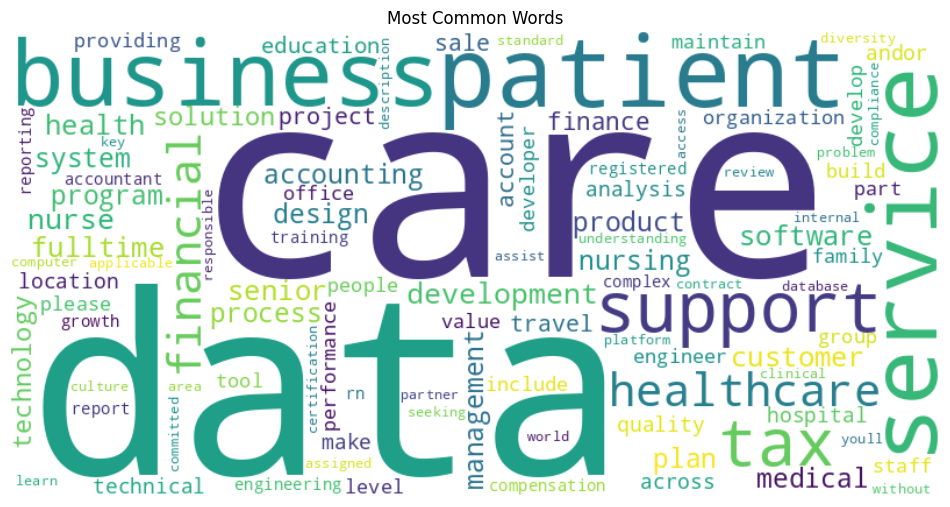

In [ ]:
# Initialize an empty list to store all words
all_words = []

# Iterate over each document in the 'skills_preprocessed'
for doc in df['texts_preprocessed']:
    # Tokenize the document into individual words
    words = nltk.word_tokenize(doc)

    # Extend the list 'all_words' with the tokenized words from the current document
    all_words.extend(words)

# Count word frequencies
word_freq = nltk.FreqDist(all_words)

# Create a WordCloud object
wc = wordcloud.WordCloud(width=800, height=400, background_color='white', max_words=100)

# Generate the word cloud using the WordCloud object and the word frequencies
wc = wc.generate_from_frequencies(word_freq)

# Plot wordcloud
plt.figure(figsize=(12, 9))
plt.axis('off') # Turn off the axis for the plot
plt.title('Most Common Words') # Set the title for the plot
plt.imshow(wc, cmap=None, interpolation='bilinear') # Display the word cloud using imshow function from matplotlib, with default colormap and bilinear interpolation
plt.show() # Show the plot with the generated word cloud

### **Most Frequent Unigrams (Words) and Bigrams (Phrases)**

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

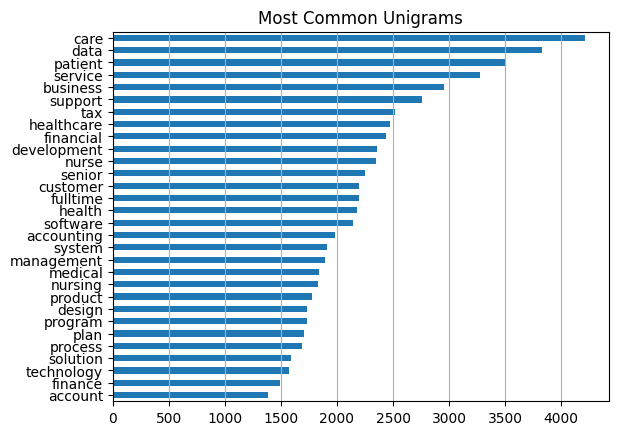

In [ ]:
top=30  # Set the number of top frequent unigrams and bigrams to display

## unigrams
# Calculate the frequency distribution of unigrams
unigram_freq = nltk.FreqDist(all_words)

# Convert the frequency distribution of unigrams to a DataFrame
unigram_df = pd.DataFrame(unigram_freq.most_common(), columns=["Word", "Freq"])

# Set the 'Word' column as index and select the top 10 unigrams rows by frequency, then sort them by ascending order of frequency
top_unigrams= unigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top unigrams as a horizontal bar plot
plt.figure()
top_unigrams.plot(kind="barh", title="Most Common Unigrams", legend=False).grid(axis='x')
plt.ylabel(None)

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

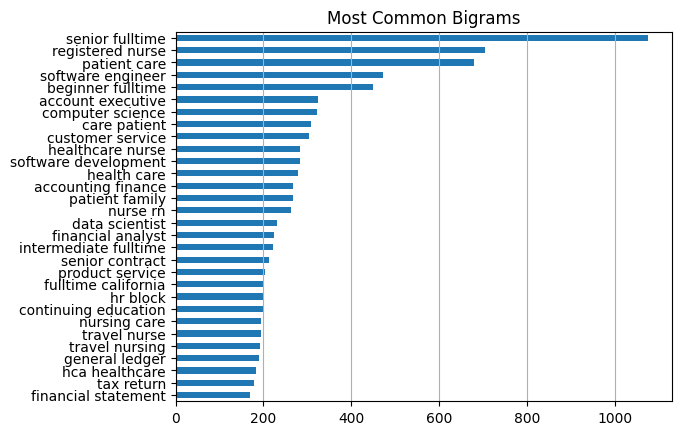

In [ ]:
## bigrams
# Calculate the frequency distribution of bigrams
bigram_freq = nltk.FreqDist(nltk.ngrams(all_words, 2))

# Convert the frequency distribution of bigrams to a DataFrame
bigram_df = pd.DataFrame(bigram_freq.most_common(), columns=["Word", "Freq"])

# Join the tokens in each bigram into a single string
bigram_df["Word"] = bigram_df["Word"].apply(lambda x: " ".join(string for string in x))

# Set the 'Word' column as index and select the top 10 bigrams by frequency, then sort them by ascending order of frequency
top_bigrams= bigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top bigrams as a horizontal bar plot
plt.figure()
top_bigrams.plot(kind="barh", title="Most Common Bigrams", legend=False).grid(axis='x')
plt.ylabel(None)

### **Identify the most common words in IT Industry**

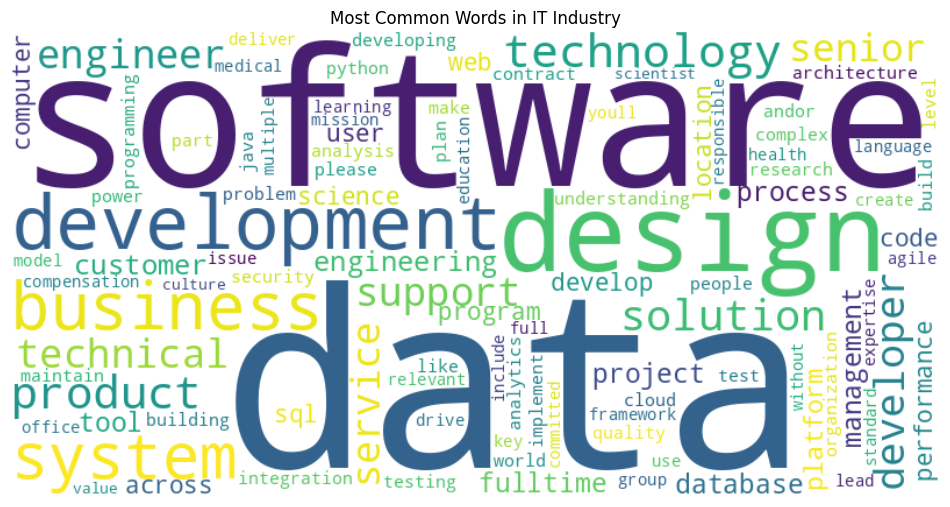

In [ ]:
# Initialize an empty list to store all words
all_words = []

# Iterate over each document in the 'skills_preprocessed'
for doc in df[df['industry']=='IT']['texts_preprocessed']:
    # Tokenize the document into individual words
    words = nltk.word_tokenize(doc)

    # Extend the list 'all_words' with the tokenized words from the current document
    all_words.extend(words)

# Count word frequencies
word_freq = nltk.FreqDist(all_words)

# Create a WordCloud object
wc = wordcloud.WordCloud(width=800, height=400, background_color='white', max_words=100)

# Generate the word cloud using the WordCloud object and the word frequencies
wc = wc.generate_from_frequencies(word_freq)

# Plot wordcloud
plt.figure(figsize=(12, 9))
plt.axis('off') # Turn off the axis for the plot
plt.title('Most Common Words in IT Industry') # Set the title for the plot
plt.imshow(wc, cmap=None, interpolation='bilinear') # Display the word cloud using imshow function from matplotlib, with default colormap and bilinear interpolation
plt.show() # Show the plot with the generated word cloud

### **Most Frequent Unigrams (Words) and Bigrams (Phrases) in IT Industry**

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

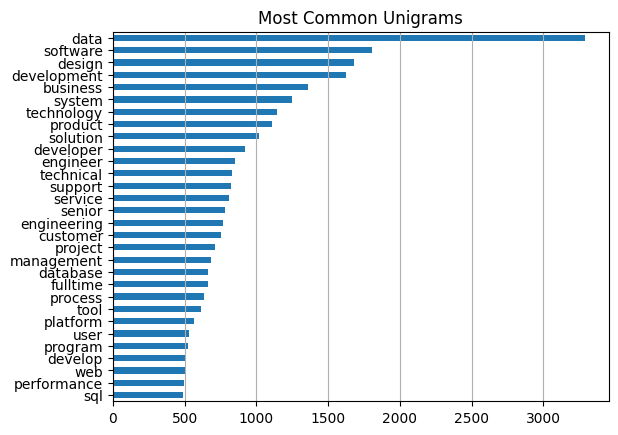

In [ ]:
top=30  # Set the number of top frequent unigrams and bigrams to display

## unigrams
# Calculate the frequency distribution of unigrams
unigram_freq = nltk.FreqDist(all_words)

# Convert the frequency distribution of unigrams to a DataFrame
unigram_df = pd.DataFrame(unigram_freq.most_common(), columns=["Word", "Freq"])

# Set the 'Word' column as index and select the top 10 unigrams rows by frequency, then sort them by ascending order of frequency
top_unigrams= unigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top unigrams as a horizontal bar plot
plt.figure()
top_unigrams.plot(kind="barh", title="Most Common Unigrams", legend=False).grid(axis='x')
plt.ylabel(None)

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

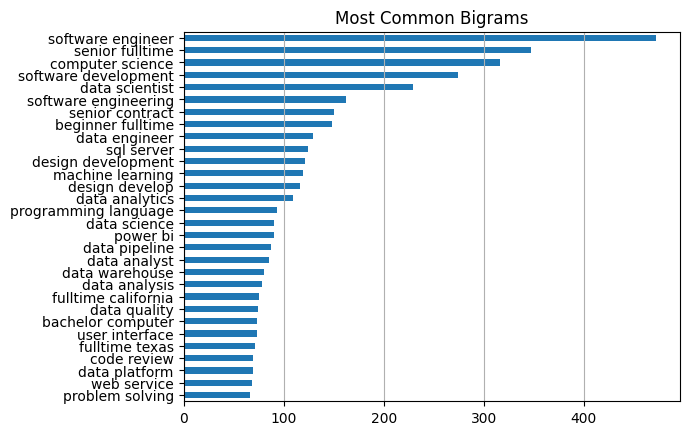

In [ ]:
## bigrams
# Calculate the frequency distribution of bigrams
bigram_freq = nltk.FreqDist(nltk.ngrams(all_words, 2))

# Convert the frequency distribution of bigrams to a DataFrame
bigram_df = pd.DataFrame(bigram_freq.most_common(), columns=["Word", "Freq"])

# Join the tokens in each bigram into a single string
bigram_df["Word"] = bigram_df["Word"].apply(lambda x: " ".join(string for string in x))

# Set the 'Word' column as index and select the top 10 bigrams by frequency, then sort them by ascending order of frequency
top_bigrams= bigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top bigrams as a horizontal bar plot
plt.figure()
top_bigrams.plot(kind="barh", title="Most Common Bigrams", legend=False).grid(axis='x')
plt.ylabel(None)

### **Identify the most common words in Healthcare Industry**

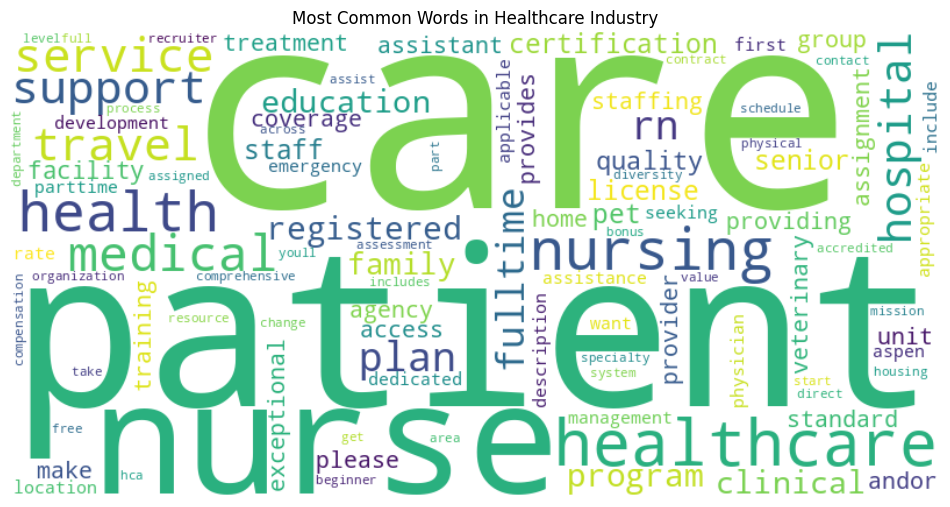

In [ ]:
# Initialize an empty list to store all words
all_words = []

# Iterate over each document in the 'skills_preprocessed'
for doc in df[df['industry']=='Healthcare']['texts_preprocessed']:
    # Tokenize the document into individual words
    words = nltk.word_tokenize(doc)

    # Extend the list 'all_words' with the tokenized words from the current document
    all_words.extend(words)

# Count word frequencies
word_freq = nltk.FreqDist(all_words)

# Create a WordCloud object
wc = wordcloud.WordCloud(width=800, height=400, background_color='white', max_words=100)

# Generate the word cloud using the WordCloud object and the word frequencies
wc = wc.generate_from_frequencies(word_freq)

# Plot wordcloud
plt.figure(figsize=(12, 9))
plt.axis('off') # Turn off the axis for the plot
plt.title('Most Common Words in Healthcare Industry') # Set the title for the plot
plt.imshow(wc, cmap=None, interpolation='bilinear') # Display the word cloud using imshow function from matplotlib, with default colormap and bilinear interpolation
plt.show() # Show the plot with the generated word cloud

### **Most Frequent Unigrams (Words) and Bigrams (Phrases) in Healthcare Industry**

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

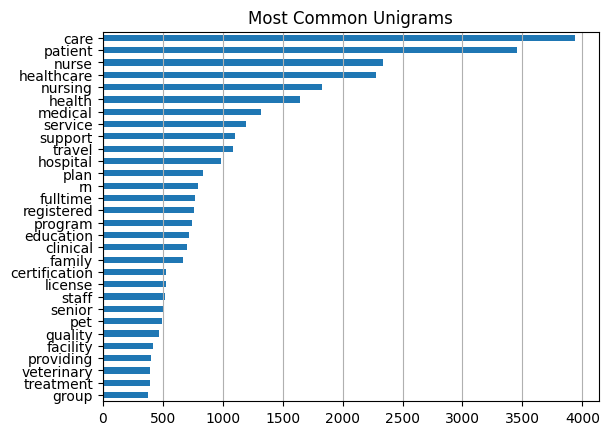

In [ ]:
top=30  # Set the number of top frequent unigrams and bigrams to display

## unigrams
# Calculate the frequency distribution of unigrams
unigram_freq = nltk.FreqDist(all_words)

# Convert the frequency distribution of unigrams to a DataFrame
unigram_df = pd.DataFrame(unigram_freq.most_common(), columns=["Word", "Freq"])

# Set the 'Word' column as index and select the top 10 unigrams rows by frequency, then sort them by ascending order of frequency
top_unigrams= unigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top unigrams as a horizontal bar plot
plt.figure()
top_unigrams.plot(kind="barh", title="Most Common Unigrams", legend=False).grid(axis='x')
plt.ylabel(None)

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

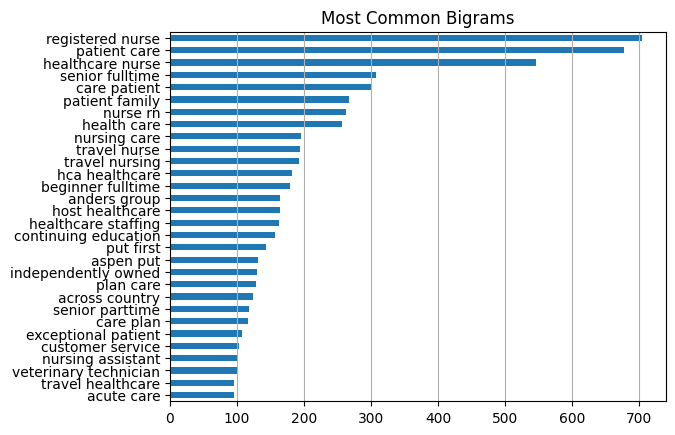

In [ ]:
## bigrams
# Calculate the frequency distribution of bigrams
bigram_freq = nltk.FreqDist(nltk.ngrams(all_words, 2))

# Convert the frequency distribution of bigrams to a DataFrame
bigram_df = pd.DataFrame(bigram_freq.most_common(), columns=["Word", "Freq"])

# Join the tokens in each bigram into a single string
bigram_df["Word"] = bigram_df["Word"].apply(lambda x: " ".join(string for string in x))

# Set the 'Word' column as index and select the top 10 bigrams by frequency, then sort them by ascending order of frequency
top_bigrams= bigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top bigrams as a horizontal bar plot
plt.figure()
top_bigrams.plot(kind="barh", title="Most Common Bigrams", legend=False).grid(axis='x')
plt.ylabel(None)

### **Identify the most common words in Finance Industry**

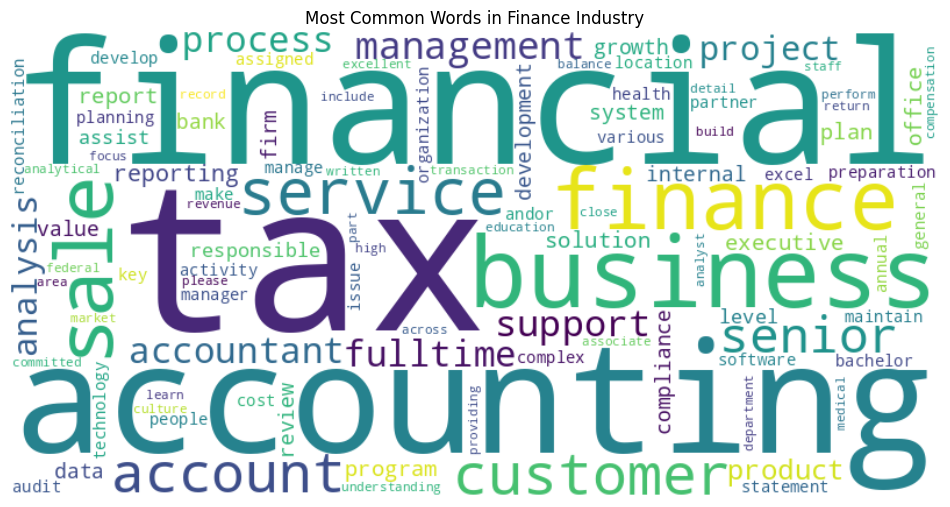

In [ ]:
# Initialize an empty list to store all words
all_words = []

# Iterate over each document in the 'skills_preprocessed'
for doc in df[df['industry']=='Finance']['texts_preprocessed']:
    # Tokenize the document into individual words
    words = nltk.word_tokenize(doc)

    # Extend the list 'all_words' with the tokenized words from the current document
    all_words.extend(words)

# Count word frequencies
word_freq = nltk.FreqDist(all_words)

# Create a WordCloud object
wc = wordcloud.WordCloud(width=800, height=400, background_color='white', max_words=100)

# Generate the word cloud using the WordCloud object and the word frequencies
wc = wc.generate_from_frequencies(word_freq)

# Plot wordcloud
plt.figure(figsize=(12, 9))
plt.axis('off') # Turn off the axis for the plot
plt.title('Most Common Words in Finance Industry') # Set the title for the plot
plt.imshow(wc, cmap=None, interpolation='bilinear') # Display the word cloud using imshow function from matplotlib, with default colormap and bilinear interpolation
plt.show() # Show the plot with the generated word cloud

### **Most Frequent Unigrams (Words) and Bigrams (Phrases) in Finance Industry**

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

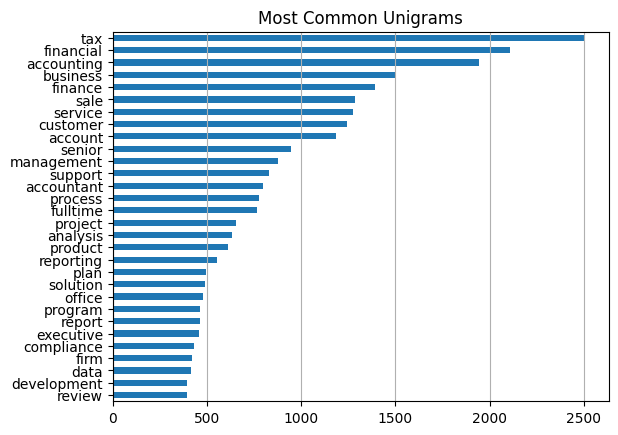

In [ ]:
top=30  # Set the number of top frequent unigrams and bigrams to display

## unigrams
# Calculate the frequency distribution of unigrams
unigram_freq = nltk.FreqDist(all_words)

# Convert the frequency distribution of unigrams to a DataFrame
unigram_df = pd.DataFrame(unigram_freq.most_common(), columns=["Word", "Freq"])

# Set the 'Word' column as index and select the top 10 unigrams rows by frequency, then sort them by ascending order of frequency
top_unigrams= unigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top unigrams as a horizontal bar plot
plt.figure()
top_unigrams.plot(kind="barh", title="Most Common Unigrams", legend=False).grid(axis='x')
plt.ylabel(None)

Text(0, 0.5, '')

<Figure size 640x480 with 0 Axes>

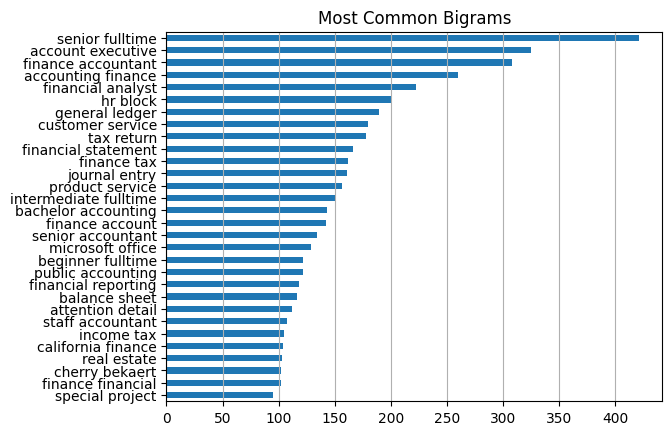

In [ ]:
## bigrams
# Calculate the frequency distribution of bigrams
bigram_freq = nltk.FreqDist(nltk.ngrams(all_words, 2))

# Convert the frequency distribution of bigrams to a DataFrame
bigram_df = pd.DataFrame(bigram_freq.most_common(), columns=["Word", "Freq"])

# Join the tokens in each bigram into a single string
bigram_df["Word"] = bigram_df["Word"].apply(lambda x: " ".join(string for string in x))

# Set the 'Word' column as index and select the top 10 bigrams by frequency, then sort them by ascending order of frequency
top_bigrams= bigram_df.set_index("Word").iloc[:top, :].sort_values(by="Freq")

# Plot the top bigrams as a horizontal bar plot
plt.figure()
top_bigrams.plot(kind="barh", title="Most Common Bigrams", legend=False).grid(axis='x')
plt.ylabel(None)

# **Vectorization**

## **TFIDF**

In [ ]:
# Instantiate TfidfVectorizer object and define parameters
tfidf_vect= TfidfVectorizer()

# Fit TfidfVectorizer it to our text corpus ie train the vectorizer object to learn what words are in the corpus and then use it to vectorize our data ie transform our data into feature vectors
df_tfidf= tfidf_vect.fit_transform(df['texts_preprocessed'])

In [ ]:
# Shape of TFIDF vectorized Text
df_tfidf.shape

(2238, 35130)

In [ ]:
# Vocabulary that TFIDF vectorizer learnt
print(tfidf_vect.vocabulary_)

{'veterinarian': 33812, 'associate': 2421, 'doctor': 9147, 'veterinary': 33818, 'equivalent': 10602, 'accredited': 387, 'university': 33235, 'active': 544, 'license': 17240, 'innovative': 15420, 'health': 13796, 'wellbeing': 34321, 'department': 8116, 'headspace': 13787, 'app': 1717, 'subscription': 30627, 'vault': 33680, 'financial': 12014, 'wellness': 34346, 'tool': 32372, 'access': 130, 'additional': 673, 'mental': 18625, 'resource': 26850, 'retirement': 27154, 'saving': 27912, 'plan': 22601, 'match': 18254, 'healthdentalvision': 13803, 'infertility': 15224, 'affirmation': 898, 'service': 28477, 'parental': 21767, 'vacation': 33577, 'development': 8529, 'continuing': 6462, 'education': 9638, 'allowance': 1198, 'academy': 110, 'mentorship': 18642, 'program': 24393, 'participate': 21800, 'mentee': 18633, 'mentor': 18637, 'gp': 13307, 'er': 10624, 'setting': 28644, 'robust': 27456, 'clinical': 5277, 'study': 30567, 'pet': 22384, 'care': 4300, 'discount': 8925, 'liability': 17223, 'cove

## **LDA**

Since we have 3 distinct industries in our dataset, we chose to apply LDA topic modelling with 3 topics.

In [ ]:
docs= list(df['texts_preprocessed'].apply(lambda x: nltk.word_tokenize(x)))

# Compute bigrams.

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Remove rare and common tokens.

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
# Train LDA model.

# Set training parameters.
num_topics = 3  # Number of topics to extract from the corpus.
chunksize = 2000  # Number of documents to be used in each training chunk.
passes = 20  # Number of passes through the corpus during training.
iterations = 400  # Maximum number of iterations through the corpus when training the model.
eval_every = None  # Do not evaluate model perplexity during training (to save time).

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token  # Create a mapping from word IDs to words.

# Train the LDA model.
lda_model = LdaModel(
    corpus=corpus,  # Bag-of-words representation of the corpus.
    id2word=id2word,  # Mapping from word IDs to words.
    chunksize=chunksize,  # Number of documents to be used in each training chunk.
    alpha='auto',  # Automatically learn the document-topic distribution.
    eta='auto',  # Automatically learn the topic-word distribution.
    iterations=iterations,  # Maximum number of iterations through the corpus.
    num_topics=num_topics,  # Number of topics to extract from the corpus.
    passes=passes,  # Number of passes through the corpus during training.
    eval_every=eval_every  # Frequency of evaluating model perplexity during training.
    )

In [ ]:
# Print topics generated by the trained LDA model
for idx, topic in lda_model.print_topics():
    print("Topic {}:".format(idx))
    print(topic) # Print the words and their corresponding probabilities in the topic.
    print()

Topic 0:
0.023*"data" + 0.010*"design" + 0.009*"software" + 0.009*"development" + 0.008*"business" + 0.007*"solution" + 0.007*"technology" + 0.007*"system" + 0.006*"product" + 0.006*"project"

Topic 1:
0.020*"care" + 0.017*"patient" + 0.014*"healthcare" + 0.014*"nurse" + 0.012*"travel" + 0.010*"nursing" + 0.009*"health" + 0.009*"medical" + 0.005*"hospital" + 0.005*"rn"

Topic 2:
0.019*"tax" + 0.013*"financial" + 0.011*"accounting" + 0.009*"finance" + 0.008*"business" + 0.007*"account" + 0.006*"sale" + 0.005*"plan" + 0.005*"customer" + 0.005*"management"



As we can see, Topic 0 highly resembles the IT industry, Topic 1 highly resembles the Healthcare industry, and Topic 2 highly resembles the Finance Industry.

In [ ]:
top_topics = lda_model.top_topics(corpus, texts=docs, dictionary=dictionary)

print('Individual Topic Coherences:')
for i in range(num_topics):
  print('Topic{}: {}'.format(i,top_topics[i][1]))

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('\nAverage topic coherence: {}'.format(avg_topic_coherence))

Individual Topic Coherences:
Topic0: -0.8059150995093591
Topic1: -0.8964236320427884
Topic2: -1.4000633285853343

Average topic coherence: -1.0341340200458273


In [ ]:
# Initialize an empty list to store the dense vectors representing topic distributions for each document.
df_lda=[]

# Iterate over each document in the tokenized document list.
for i in range(len(docs)):
  # Get the topic distribution for the ith document
  lda_vector= lda_model[dictionary.doc2bow(docs[i])]

  # Convert the topic distribution to a dense vector
  dense_vector = gensim.matutils.sparse2full(lda_vector,lda_model.num_topics)

  # Append the dense vector representation of the topic distribution to the data_lda list.
  df_lda.append(dense_vector)

# Convert the list of dense vectors to a pandas DataFrame.
df_lda= pd.DataFrame(df_lda)

In [ ]:
df_lda

0         1         2
0     0.000000  0.802031  0.197122
1     0.000000  0.801365  0.197788
2     0.000000  0.806491  0.192673
3     0.000000  0.798037  0.201116
4     0.000000  0.797580  0.201573
...        ...       ...       ...
2233  0.999596  0.000000  0.000000
2234  0.000000  0.000000  0.999680
2235  0.999628  0.000000  0.000000
2236  0.000000  0.000000  0.999551
2237  0.000000  0.000000  0.999102

[2238 rows x 3 columns]

In [ ]:
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.4 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.144520  0.119603       1        1  35.958201
1     -0.200153  0.041563       2        1  33.846844
2      0.055633 -0.161166       3        1  30.194955, topic_info=                 Term         Freq        Total Category  logprob  loglift
969              data  4535.000000  4535.000000  Default  30.0000  30.0000
1303              tax  3121.000000  3121.000000  Default  29.0000  29.0000
265           patient  3109.000000  3109.000000  Default  28.0000  28.0000
9                care  3801.000000  3801.000000  Default  27.0000  27.0000
259             nurse  2441.000000  2441.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
938            assist   393.861936   706.748438   Topic3  -6.0086   0.6128
51    senior_fulltime   422.655150  1074.555089   Topic3  -5.9380   0.2644
298             andor   402.374125  1049.050817   Topic3  -5.9872   0.2392
425           product   409.418031  1617.253542   Topic3  -5.9698  -0.1763
24             health   384.132926  2153.389111   Topic3  -6.0336  -0.5263

[211 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
220       1  0.014011            account
220       2  0.097256            account
220       3  0.888493            account
1541      3  0.997719  account_executive
1236      3  0.998410         accountant
...     ...       ...                ...
2575      1  0.999307                web
7519      2  0.995562          weekshift
63        1  0.004204          wellbeing
63        2  0.189181          wellbeing
63        3  0.807174          wellbeing

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# **K-Means Clustering**

In [ ]:
def perform_kmeans(data, n_clusters=4):
    kmeans = KMeans(n_clusters, random_state=42,init='k-means++')
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels, kmeans.cluster_centers_, kmeans

##**K-Means with TFIDF**

### **Find optimal number of clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

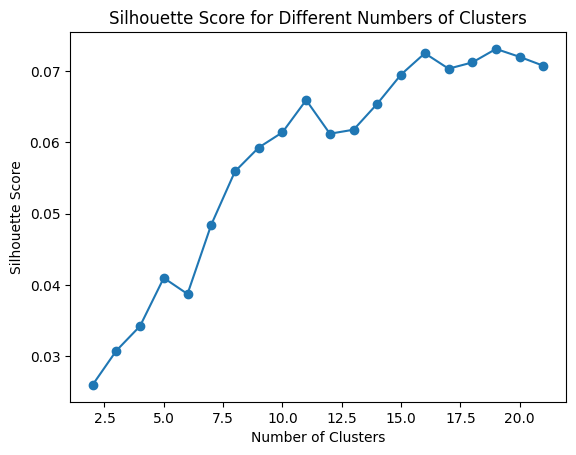

For n_clusters = 2 The average silhouette_score is : 0.025968259640982122
For n_clusters = 3 The average silhouette_score is : 0.03076517290034321
For n_clusters = 4 The average silhouette_score is : 0.03422226634333888
For n_clusters = 5 The average silhouette_score is : 0.04097664879969991
For n_clusters = 6 The average silhouette_score is : 0.03872490460739472
For n_clusters = 7 The average silhouette_score is : 0.048436274779685165
For n_clusters = 8 The average silhouette_score is : 0.0559120887208303
For n_clusters = 9 The average silhouette_score is : 0.059263208968329345
For n_clusters = 10 The average silhouette_score is : 0.06139926707577925
For n_clusters = 11 The average silhouette_score is : 0.06592508934437152
For n_clusters = 12 The average silhouette_score is : 0.061205408339100535
For n_clusters = 13 The average silhouette_score is : 0.061769541264947984
For n_clusters = 14 The average silhouette_score is : 0.06542312539924555
For n_clusters = 15 The average silhouette

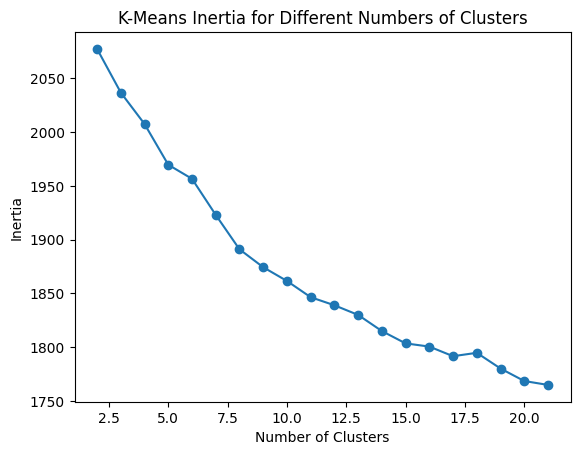

In [ ]:
silhouette_scores = []
sse = []

# Iterate through batches of data
for i in range(2, 22):
  kmeans = KMeans(n_clusters = i,random_state=42,init='k-means++')
  cluster_labels = kmeans.fit_predict(df_tfidf)
  silhouette_scores.append(silhouette_score(df_tfidf, cluster_labels))
  sse.append(kmeans.inertia_)

# Plot silhouette scores for different numbers of clusters
plt.plot(range(2, 22), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

# Print the silhouette scores
for n_clusters, silhouette_avg in zip(range(2, 22), silhouette_scores):
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

# Plot inertia for different numbers of clusters
plt.plot(range(2,22),sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-Means Inertia for Different Numbers of Clusters')
plt.show()

##**K-Means with LDA**

### **Find optimal number of clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

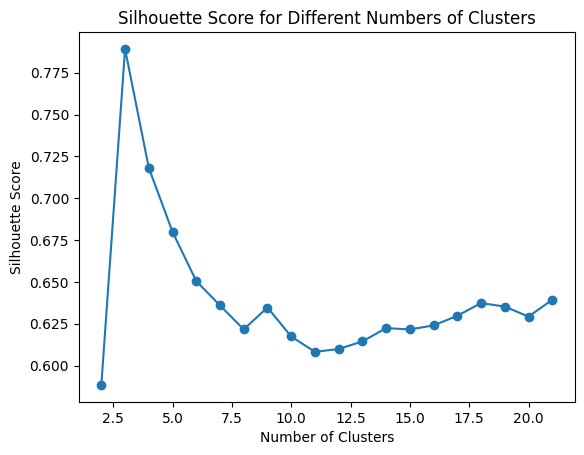

For n_clusters = 2 The average silhouette_score is : 0.5884665
For n_clusters = 3 The average silhouette_score is : 0.7892074
For n_clusters = 4 The average silhouette_score is : 0.71818304
For n_clusters = 5 The average silhouette_score is : 0.6799026
For n_clusters = 6 The average silhouette_score is : 0.6505277
For n_clusters = 7 The average silhouette_score is : 0.6359562
For n_clusters = 8 The average silhouette_score is : 0.6216723
For n_clusters = 9 The average silhouette_score is : 0.63471717
For n_clusters = 10 The average silhouette_score is : 0.61741483
For n_clusters = 11 The average silhouette_score is : 0.6082279
For n_clusters = 12 The average silhouette_score is : 0.60993713
For n_clusters = 13 The average silhouette_score is : 0.61445284
For n_clusters = 14 The average silhouette_score is : 0.6224096
For n_clusters = 15 The average silhouette_score is : 0.6216188
For n_clusters = 16 The average silhouette_score is : 0.6240262
For n_clusters = 17 The average silhouette_

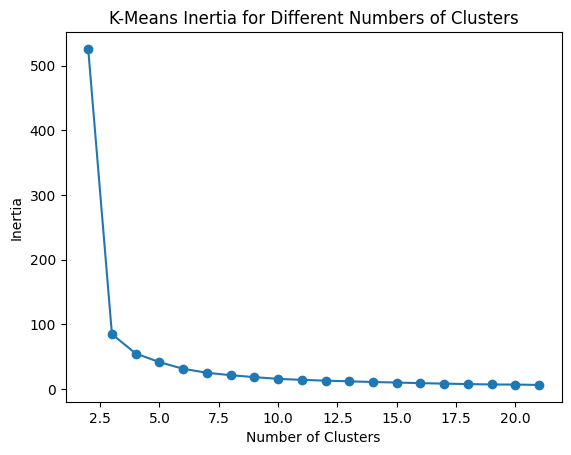

In [ ]:
silhouette_scores = []
sse = []

# Iterate through batches of data
for i in range(2, 22):
  kmeans = KMeans(n_clusters = i,random_state=42,init='k-means++')
  cluster_labels = kmeans.fit_predict(df_lda)
  silhouette_scores.append(silhouette_score(df_lda, cluster_labels))
  sse.append(kmeans.inertia_)

# Plot silhouette scores for different numbers of clusters
plt.plot(range(2, 22), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

# Print the silhouette scores
for n_clusters, silhouette_avg in zip(range(2, 22), silhouette_scores):
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

# Plot inertia for different numbers of clusters
plt.plot(range(2,22),sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-Means Inertia for Different Numbers of Clusters')
plt.show()

## **Champion: K-Means + LDA**

K-Means with TFIDF got very low silhouette scores (lower than 0.1) and requires a high number of clusters which is not compatible with a medium-sized dataset. K-Means with LDA was able to achieve a very good silhouette score of 0.78 for number of clusters = 3. This is quite reasonable since we have 3 distinct industries and since we vectorized our data using LDA topic modelling with 3 topics. Therefore, K-Means with LDA is our champion model.

In [ ]:
# Functions to reduce dimensionality (will be used for visualizations)
def get_TSNE(data):
  tsne = TSNE(n_components=2, random_state=42)
  data_tsne = tsne.fit_transform(data)
  return data_tsne

In [ ]:
# Function to plot 2D data as per label
def plotData(X2D,y,labels):
    # Define a list of 35 distinct colors
    # Define a list of 35 visually distinct colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78',
              '#98df8a', '#ff9896', '#c5b0d5', '#ff8c00', '#1e90ff', '#ff1493',
              '#00ff00', '#ff0000', '#00ffff', '#ffff00', '#800080', '#008080',
              '#ff4500', '#ff69b4', '#696969', '#9932cc', '#cd5c5c', '#00fa9a',
              '#4682b4', '#ff6347', '#d2b48c', '#8a2be2', '#ff00ff','#32cd32']

    # Shuffle the colors randomly
    plt.figure(figsize=(8, 6))
    plt.xlabel('X1')
    plt.ylabel('X2')
    for K in range(len(labels)):
        cluster_data = X2D[y == labels[K]]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=labels[K], c=colors[K])

        # Annotate each cluster with its label number
        #centroid = np.mean(cluster_data, axis=0)
        #plt.annotate(str(labels[K]), xy=centroid, xytext=(-10, 10),
                     #textcoords='offset points', ha='center', va='center',
                     #bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    plt.legend()

### **TSNE transform of LDA vectorized data**

In [ ]:
# Transform data to 2D tsne to plot
df_lda_tsne= get_TSNE(df_lda)

### **Get cluster labels and centers for LDA vectorized data with num_clusters= 3**

In [ ]:
cluster_labels_lda1, cluster_centers_lda1, kmeans_lda_model =perform_kmeans(df_lda, n_clusters=3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df['cluster_labels_lda1']=cluster_labels_lda1

### **Visualize LDA vectorized data labeled as per Ground Truth and as per K-Means clusters**

Text(0.5, 1.0, 'LDA Data labeled with KMeans')

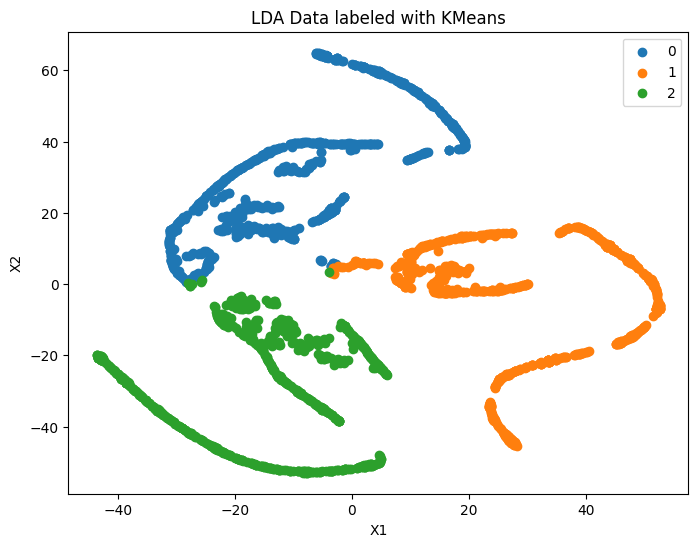

In [ ]:
plotData(df_lda_tsne,cluster_labels_lda1,[0,1,2])
plt.title('LDA Data labeled with KMeans')

Text(0.5, 1.0, 'LDA Data labeled with Ground Truth')

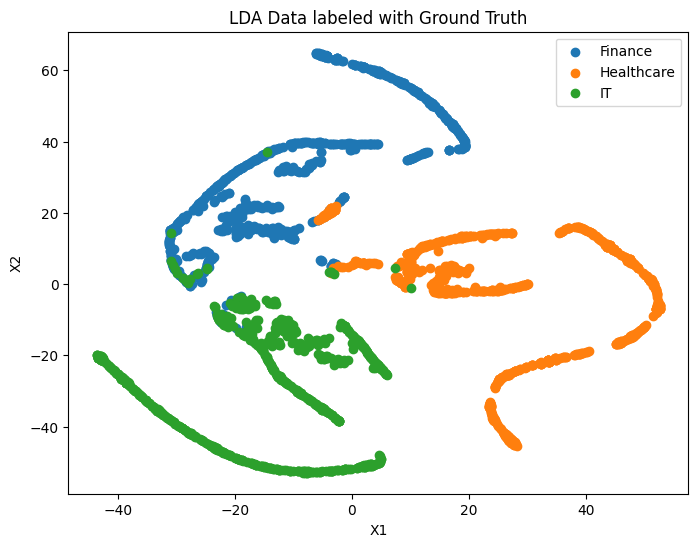

In [ ]:
plotData(df_lda_tsne,df['industry'],['Finance','Healthcare','IT'])
plt.title('LDA Data labeled with Ground Truth')

As we can see, K-Means with 3 clusters has successfully partitioned the data into well-defined clusters. Also, we can see that Cluster 0 consists mostly of finance industry, Cluster 1 consists mostly of healthcare industry, and Cluster 2 consists mostly of mostly IT industry. Therefore, we can say tha tK-Means with 3 clusters has effectively captured the underlying industry distribution of the data, resulting in meaningful and distinct clusters.

### **Explore industry distribution for each cluster**

In [ ]:
for label in df['cluster_labels_lda1'].unique():
  print('\n\nCluster {}:'.format(label))
  print(df[df['cluster_labels_lda1']==label]['industry'].value_counts())



Cluster 1:
Healthcare    697
IT              5
Finance         1
Name: industry, dtype: int64


Cluster 0:
Finance       734
Healthcare     35
IT             14
Name: industry, dtype: int64


Cluster 2:
IT         724
Finance     28
Name: industry, dtype: int64


### **Explore job title distribution for each cluster**

In [ ]:
for label in df['cluster_labels_lda1'].unique():
  print('\n\nCluster {}:'.format(label))
  print(df[df['cluster_labels_lda1']==label]['job_title'].value_counts())



Cluster 1:
Nurse                    546
Veterinarian              42
Nursing Assistant         37
Dental Assistant          24
Veterinary Technician     17
Veterinary Assistant      15
Dental Hygienist          10
Dentist                    6
Data Scientist             3
Software Engineer          1
Account Executive          1
Developer                  1
Name: job_title, dtype: int64


Cluster 0:
Accountant               308
Tax Professional         147
Account Executive        121
Financial Analyst         94
Banker                    48
Dental Hygienist          35
Portfolio Manager          9
Data Scientist             8
Retirement Specialist      7
Developer                  6
Name: job_title, dtype: int64


Cluster 2:
Developer              287
Software Engineer      200
Data Scientist         107
Data Engineer           53
UI/UX Designer          42
Database Management     35
Account Executive       20
Financial Analyst        5
Portfolio Manager        3
Name: job_title, dty

## **K-Means with TFIDF (WILL NOT BE USED)**

In [ ]:
# Expand the sparse matrix to a collection of arrays and store collection of arrays to a data frame
df_tfidf_expanded= pd.DataFrame(df_tfidf.toarray())
df_tfidf_expanded.columns= tfidf_vect.get_feature_names_out()
# Transform data to 2D tsne to plot
df_tfidf_tsne= get_TSNE(df_tfidf_expanded)

In [ ]:
cluster_labels_tfidf2, cluster_centers_tfidf2, kmeans_tfidf_model=perform_kmeans(df_tfidf, n_clusters=19)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df['cluster_labels_tfidf2']=cluster_labels_tfidf2

Text(0.5, 1.0, 'tfidf Data labeled with KMeans')

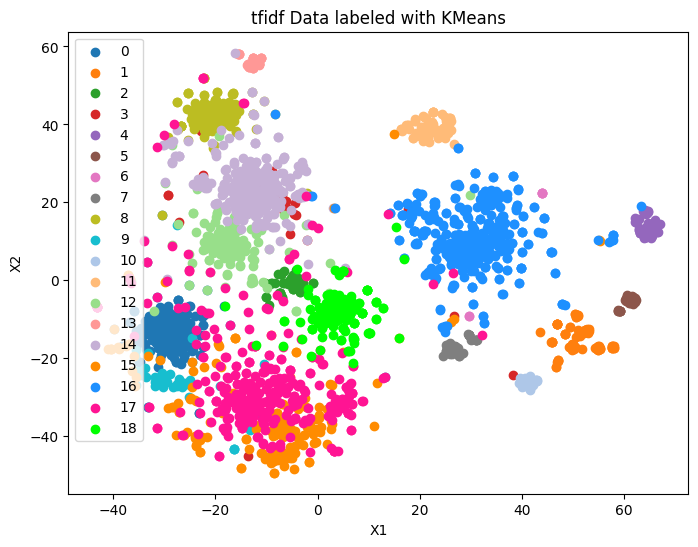

In [ ]:
plotData(df_tfidf_tsne,cluster_labels_tfidf2,np.unique(cluster_labels_tfidf2))
plt.title('tfidf Data labeled with KMeans')

Text(0.5, 1.0, 'tfidf Data labeled with Ground Truth')

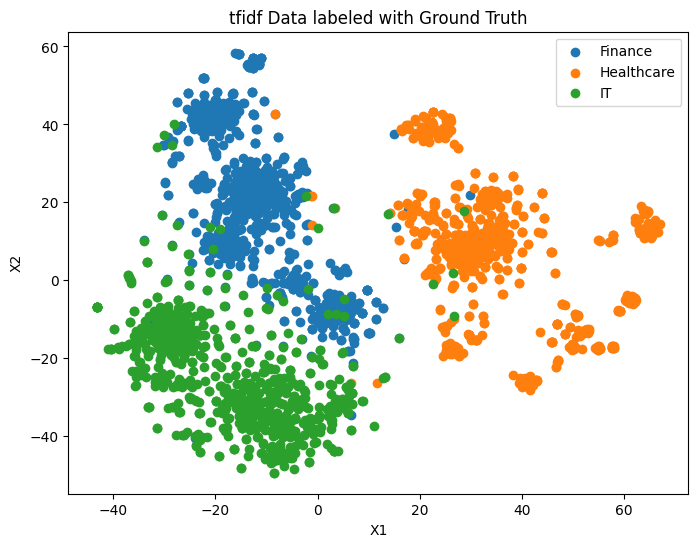

In [ ]:
plotData(df_tfidf_tsne,df['industry'],['Finance','Healthcare','IT'])
plt.title('tfidf Data labeled with Ground Truth')

In [ ]:
for label in df['cluster_labels_tfidf2'].unique():
  print('\n\nCluster {}:'.format(label))
  print(df[df['cluster_labels_tfidf2']==label]['industry'].value_counts())



Cluster 11:
Healthcare    74
Name: industry, dtype: int64


Cluster 16:
Healthcare    391
IT              1
Name: industry, dtype: int64


Cluster 2:
Finance    53
Name: industry, dtype: int64


Cluster 4:
Healthcare    53
Name: industry, dtype: int64


Cluster 17:
IT            332
Finance        11
Healthcare      3
Name: industry, dtype: int64


Cluster 5:
Healthcare    33
Name: industry, dtype: int64


Cluster 14:
Finance    252
Name: industry, dtype: int64


Cluster 8:
Finance    127
Name: industry, dtype: int64


Cluster 12:
Finance    122
IT           9
Name: industry, dtype: int64


Cluster 18:
Finance    139
IT           5
Name: industry, dtype: int64


Cluster 10:
Healthcare    30
Name: industry, dtype: int64


Cluster 0:
IT         169
Finance      1
Name: industry, dtype: int64


Cluster 15:
IT            174
Healthcare      5
Finance         2
Name: industry, dtype: int64


Cluster 9:
IT    51
Name: industry, dtype: int64


Cluster 6:
Healthcare    6
Name: industry, dtyp

In [ ]:
for label in df['cluster_labels_tfidf2'].unique():
  print('\n\nCluster {}:'.format(label))
  print(df[df['cluster_labels_tfidf2']==label]['job_title'].value_counts())



Cluster 11:
Veterinarian             41
Veterinary Technician    17
Veterinary Assistant     15
Nurse                     1
Name: job_title, dtype: int64


Cluster 16:
Nurse                345
Nursing Assistant     27
Dental Hygienist      10
Dental Assistant       7
Dentist                2
Data Scientist         1
Name: job_title, dtype: int64


Cluster 2:
Banker               48
Portfolio Manager     5
Name: job_title, dtype: int64


Cluster 4:
Nurse    53
Name: job_title, dtype: int64


Cluster 17:
Software Engineer        181
Developer                 86
UI/UX Designer            40
Data Scientist            17
Database Management        5
Tax Professional           5
Retirement Specialist      4
Data Engineer              3
Account Executive          2
Nurse                      2
Dental Assistant           1
Name: job_title, dtype: int64


Cluster 5:
Nurse    33
Name: job_title, dtype: int64


Cluster 14:
Accountant           242
Tax Professional       7
Financial Analyst     

# **Save Data with Cluster Labels**

In [ ]:
df.to_csv('labeled_linkedin_jobs.csv',index=False)

# **Pickle tfidf vectorizer, lda vectorizer, dictionary, kmeans clusterer with tfidf, and kmeans clusterer with lda**

In [ ]:
import pickle

with open("lda_vect.pickle", "wb") as file:
  pickle.dump(lda_model,file,protocol = pickle.HIGHEST_PROTOCOL)

with open("dictionary.pickle", "wb") as file:
  pickle.dump(dictionary,file)

with open("tfidf_vect.pickle", "wb") as file:
  pickle.dump(tfidf_vect,file,protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("kmeans__lda_model.pickle", "wb") as file:
  pickle.dump(kmeans_lda_model,file)

with open("kmeans_tfidf_model.pickle", "wb") as file:
  pickle.dump(kmeans_tfidf_model,file)